In [1]:
import pandas as pd
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, reweight_laplace
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')

In [2]:
# load mobility matrix
data = pd.read_csv('../../../Dropbox/Epidemiology/trajectories/nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=0)

array([3.04470101, 0.63298709, 0.65432751, 1.5175129 , 0.78085325,
       0.6341433 , 0.87459994, 1.00571173, 0.68504912, 1.01402755,
       0.63915968, 0.65825195, 0.66197261, 1.04407087, 2.80167096,
       0.80280225, 0.83361601, 0.67170434, 0.66538914, 0.48316792,
       0.5704564 , 0.52324962, 1.10463661, 1.22121747, 0.52581269,
       0.58765684, 0.50016525, 3.22377082, 0.69175819, 1.20546935,
       4.12656194, 0.67824499, 1.75265207, 2.67871074, 1.18177785,
       1.11429053, 0.44422598, 0.63481357, 0.87829422, 0.30881013,
       1.04058779, 0.68213382, 0.38948335, 0.74921793, 0.97165063,
       1.27478184, 0.9820337 , 0.50643875, 0.39695896, 0.53155178,
       1.06668606, 1.25653031, 0.60235276, 0.41815181, 1.51938207,
       0.82304881, 0.99505599, 0.47844257, 0.57760229, 1.59708697,
       0.55656234, 0.52596506])

In [3]:
# compartment parameters
C = 4

def make_trans_mats(N):
    T = np.zeros((N,C,C))
    dist = lambda : ss.beta.rvs(1, 100)
    for i in range(N):
        Ti = np.zeros((C,C))
        Ti[0,1] = dist()
        Ti[0,2] = dist()
        Ti[1,3] = dist()
        Ti[2,3] = dist()
        # get what leaves
        np.fill_diagonal(Ti, 1 - np.sum(Ti, axis=1))
        T[i] = Ti
    return T
T = make_trans_mats(1)
print(T[0])
print([1,0,0,0] @ T[0])

[[0.96783192 0.02938112 0.00278695 0.        ]
 [0.         0.99787315 0.         0.00212685]
 [0.         0.         0.98621259 0.01378741]
 [0.         0.         0.         1.        ]]
[0.96783192 0.02938112 0.00278695 0.        ]


In [4]:
f = [0.8,0,0,0]
for i in range(3):
    f = f @ T[0]
    #f = np.clip(f, 0,1)
    #f /= np.sum(f)
    print(f, np.sum(f))

[0.77426554 0.0235049  0.00222956 0.        ] 0.8
[7.49358906e-01 4.62037009e-02 4.35666177e-03 8.07311650e-05] 0.7999999999999999
[7.25253472e-01 6.81224403e-02 6.38502158e-03 2.39066381e-04] 0.8


In [5]:
# starting fractions
def make_starts(N):
    start = np.zeros((N, M, C))
    # pick 2 starting patches
    seeds = [[0, 1]]
    for i in range(N):
        for j in np.random.randint(0, M, size=5): #seeds:
            start[i,j,0] = ss.beta.rvs(1, 100)
    return start

In [6]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 256
batches = 8
outs = []
for b in tqdm.tqdm(range(batches)):
    start = make_starts(N)
    Rmat = np.tile(R[np.newaxis,:,:], [N,1,1])
    infect = contact_infection_func(tf.constant([np.random.uniform(0.01,0.2) for _ in range(N)]))
    T = make_trans_mats(N)
    model = MetaModel(start, Rmat, T, infect)
    outs.append(model.run(1000))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.44s/it]


(2048, 1000, 62, 5)


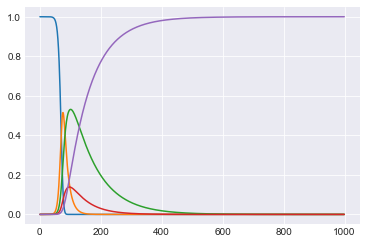

In [7]:
plt.plot(trajs[0,:,0,:])
plt.show()

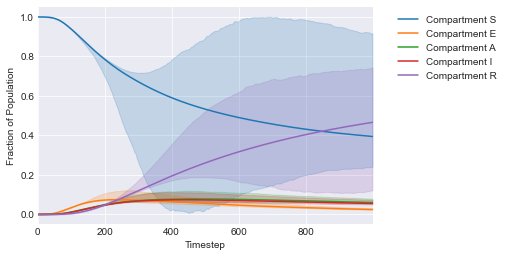

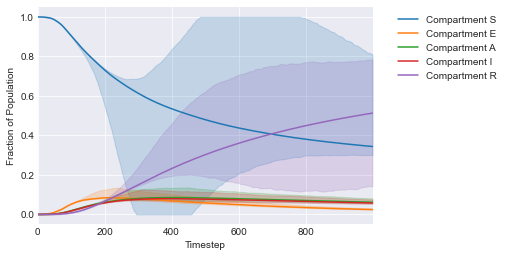

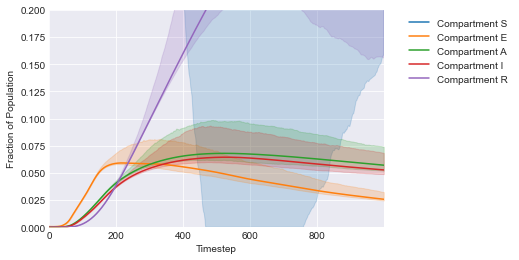

In [8]:
traj_quantile(trajs[:,:,0,:], names=['S', 'E', 'A', 'I', 'R'], plot_means=True)
plt.show()
traj_quantile(trajs[:,:,1,:], names=['S', 'E', 'A', 'I', 'R'], plot_means=True)
plt.show()
traj_quantile(trajs[:,:,2,:], names=['S', 'E', 'A', 'I', 'R'], plot_means=True)
plt.ylim(0,0.2)
plt.show()

In [10]:
restraints = np.array([
    [0.4, 0, 250, 0, 0],
    [0.12,0.05,200,2,1],
    [0.8, 0.1,900, 1, 4],
    [0.6, 0, 250, 34, 4],
    [0.4, 0, 250, 24, 0],
             ])
laplace_restraints = []
for i in range(len(restraints)):
    traj_index = tuple(restraints[i, 2:].astype(np.int))
    value = restraints[i, 0]
    uncertainty = restraints[i, 1]
    p = maxentep.Laplace(uncertainty) if uncertainty > 0 else maxentep.EmptyPrior()
    r = maxentep.Restraint(lambda traj: traj[traj_index], value, p)
    laplace_restraints.append(r)

In [11]:
trajs.shape

(2048, 1000, 62, 5)

In [12]:
model = maxentep.MaxentModel(len(laplace_restraints))
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), 'mean_squared_error')

In [13]:
history = model.fit(trajs, laplace_restraints, batch_size=32, epochs=30)

Epoch 1/30
64/64 [==============================] - 0s 2ms/step - loss: 0.1711 - output_2_loss: 0.1711
Epoch 2/30
64/64 [==============================] - 0s 3ms/step - loss: 0.1588 - output_2_loss: 0.1588
Epoch 3/30
64/64 [==============================] - 0s 3ms/step - loss: 0.1408 - output_2_loss: 0.1408
Epoch 4/30
64/64 [==============================] - 0s 2ms/step - loss: 0.1224 - output_2_loss: 0.1224
Epoch 5/30
64/64 [==============================] - 0s 2ms/step - loss: 0.1037 - output_2_loss: 0.1037
Epoch 6/30
64/64 [==============================] - 0s 2ms/step - loss: 0.0870 - output_2_loss: 0.0870
Epoch 7/30
64/64 [==============================] - 0s 3ms/step - loss: 0.0763 - output_2_loss: 0.0763
Epoch 8/30
64/64 [==============================] - 0s 3ms/step - loss: 0.0674 - output_2_loss: 0.0674
Epoch 9/30
64/64 [==============================] - 0s 3ms/step - loss: 0.0628 - output_2_loss: 0.0628
Epoch 10/30
64/64 [==============================] - 0s 3ms/step - loss: 

In [14]:
model.summary()

Model: "maxent-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
maxent_layer (MaxentLayer)   multiple                  5         
_________________________________________________________________
reweight_layer (ReweightLaye multiple                  5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


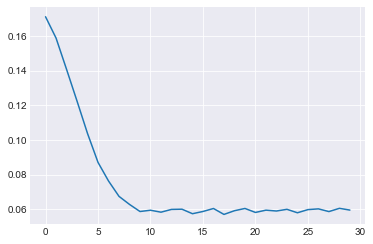

In [15]:
plt.plot(history.history['loss'])

(array([1259.,   80.,   58.,   51.,   49.,   33.,   43.,   50.,   50.,
         375.]),
 array([0.00028624, 0.00035814, 0.00043004, 0.00050193, 0.00057383,
        0.00064572, 0.00071762, 0.00078951, 0.00086141, 0.00093331,
        0.0010052 ], dtype=float32),
 <a list of 10 Patch objects>)

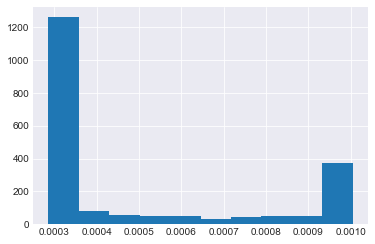

In [16]:
weights = model.traj_weights
plt.hist(weights)

In [ ]:
patch_quantile(trajs, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

Plotting 62 patches in a 7 x 9 grid


In [ ]:
patch_quantile(trajs, weights=weights, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

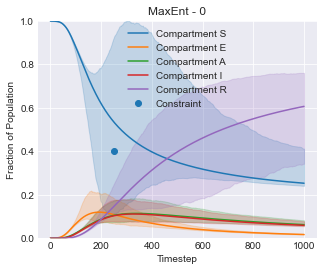

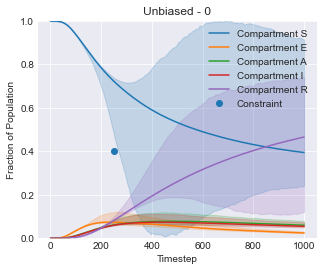

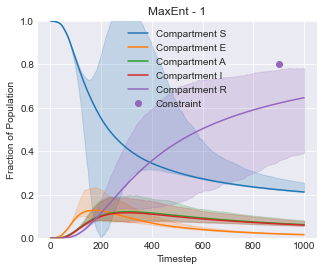

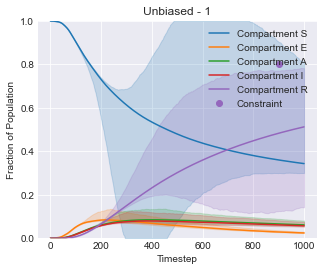

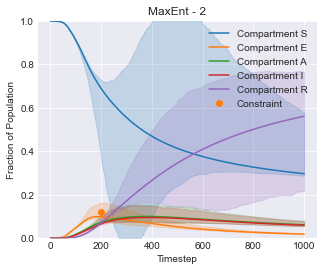

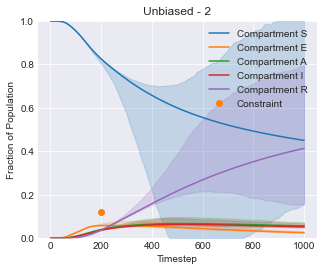

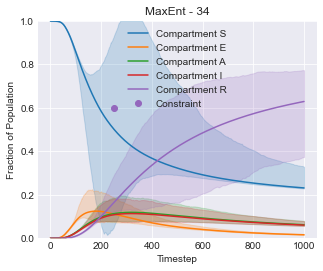

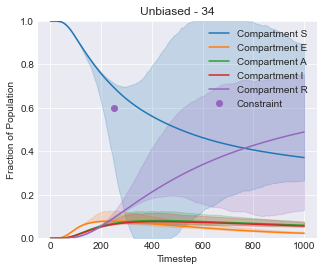

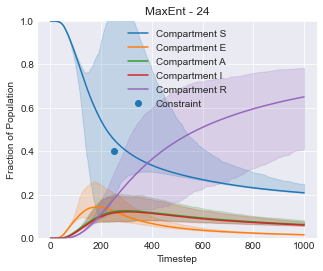

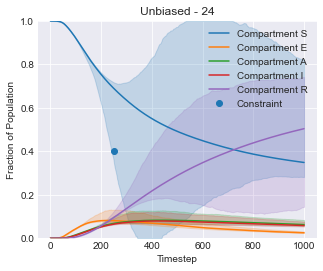

In [17]:
for p in [0,1,2,34,24]:
    plt.figure(figsize=(5,4))
    plt.title(f'MaxEnt - {p}')
    traj_quantile(trajs[:,:,p,:], weights, add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            #plt.errorbar(r[2], r[0], yerr=pr.prior.expected(all_lambdas[-1][i]), color=f'C{r[-1]}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'Unbiased - {p}')
    traj_quantile(trajs[:,:,p,:], add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            #plt.errorbar(r[2], r[0], yerr=pr.prior.expected(all_lambdas[-1][i]), color=f'C{r[-1]}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()